<a href="https://colab.research.google.com/github/tackulus/206428/blob/main/RSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from math import gcd, sqrt
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn
lcm = lambda x, y: (x*y) // gcd(x, y)

def isPrime(n):
    if n <= 1: return False
    i = 2
    while i <= sqrt(n):
        if n % i == 0: return False
        i += 1
    return True

PrimeList = lambda m, n: [p for p in range(m, n+1) if isPrime(p)]
PhiPrime = lambda p, q: (p-1) * (q-1)
isKey = lambda k, phi: gcd(k, phi) == 1
KeyList = lambda phi: [e for e in range(2, phi) if isKey(e, phi)]
UCCnumber = lambda e, p, q: ( 1 + gcd(e-1,p-1) ) * ( 1 + gcd(e-1,q-1) )
DGKnumber = lambda p, q: int(PhiPrime(p, q) / lcm(p-1, q-1) - 1)

In [2]:
def simulator(minp, maxp, rep=1):
    results = []
    plst = PrimeList(minp, maxp)
    for i in range(rep):
        p, q = random.sample(plst, 2)
        n = p * q
        phi = PhiPrime(p, q)    
        klst = KeyList(phi)
        UCClst = [UCCnumber(e, p, q) for e in klst] 
        results.append( (n, p, q, klst, UCClst) )
    return results

In [3]:
def plotUCC(results, figsize=(16,8)):
    plt.figure(figsize=figsize)
    plt.axhline(y=9, ls='--', color='000000', alpha=0.8)
    alphas = [1, 0.8, 0.4]
    for i, result in enumerate(results):
        n, _, _, klst, UCClst = result
        alpha = alphas[i]
        plt.scatter(klst, UCClst, alpha=alpha, label=f'n = {n}')
        plt.axhline(y=n, ls='--', color='000000', alpha=0.8)
    plt.xlabel('Public Key : e')
    plt.ylabel('The number of unconcealed messages')
    plt.legend()
    plt.show()

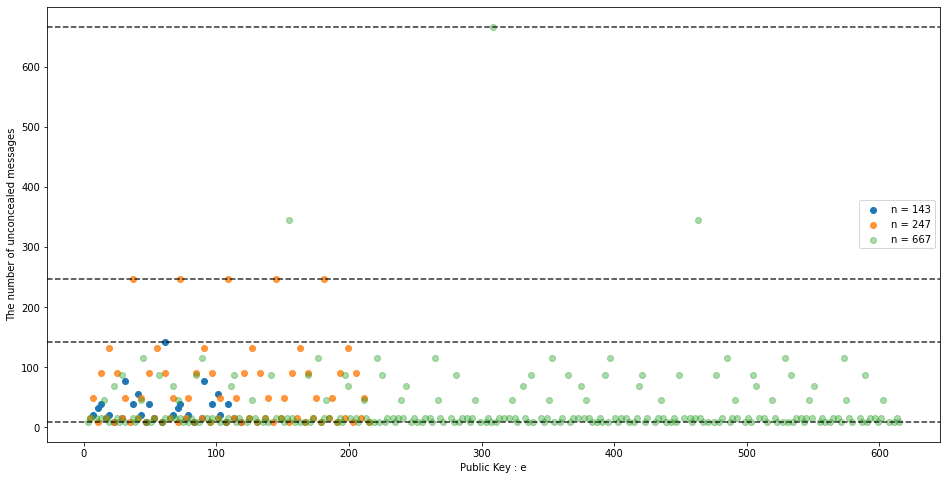

In [4]:
result1 = simulator(10, 15)
result2 = simulator(10, 20)
result3 = simulator(20, 30)
results = result1 + result2 + result3
plotUCC(results)

In [5]:
def generatePlaintext(mod, lenght=1):
    omega = [i for i in range(mod)]
    texts = [random.sample(omega, 1)[0] for i in range(lenght)]
    return texts
generatePlaintext(13, 20)


[10, 5, 11, 5, 12, 9, 3, 11, 2, 3, 1, 0, 0, 0, 5, 11, 11, 8, 5, 8]

In [6]:
encryptRSA = lambda x, n, e: x**e % n

In [7]:
def countUCC(lst1, lst2):
    boo = [x==y for x,y in zip(lst1, lst2)]
    return sum(boo)

countUCC([1,2,3], [1,1,3])

2

In [8]:
def randomParams(minp, maxp):
    plst = PrimeList(minp, maxp)
    p, q = random.sample(plst, 2)
    n = p * q
    phi = PhiPrime(p, q)
    return n, p, q, phi

In [11]:
def simulator2(minp, maxp, rep=1, minl=1, maxl=1000):
    n, p, q, phi = randomParams(minp, maxp)
    klst = KeyList(phi)
    UCC = lambda e: UCCnumber(e,p,q)
    leastUCC = min([UCC(e) for e in klst])
    klst_least = []
    klst_not = []
    for e in klst:
        if UCC(e) == n: pass
        elif UCC(e) == leastUCC: klst_least.append(e)
        else: klst_not.append(e)

    def subsimulator(klst):
        resultlst = {'lenght': [], 'UCC': []}
        for r in range(rep):
            lenght = random.randint(minl, maxl)
            texts = generatePlaintext(n, lenght)
            e = random.sample(klst, 1)[0]
            y = [encryptRSA(x, n, e) for x in texts]
            resultlst['lenght'].append(lenght)
            resultlst['UCC'].append(countUCC(texts, y))
        return resultlst

    l = subsimulator(klst_least)
    t = subsimulator(klst_not)
        
    return n, p, q, l, t

n, *_, l, t = simulator2(10, 30, rep=1000)


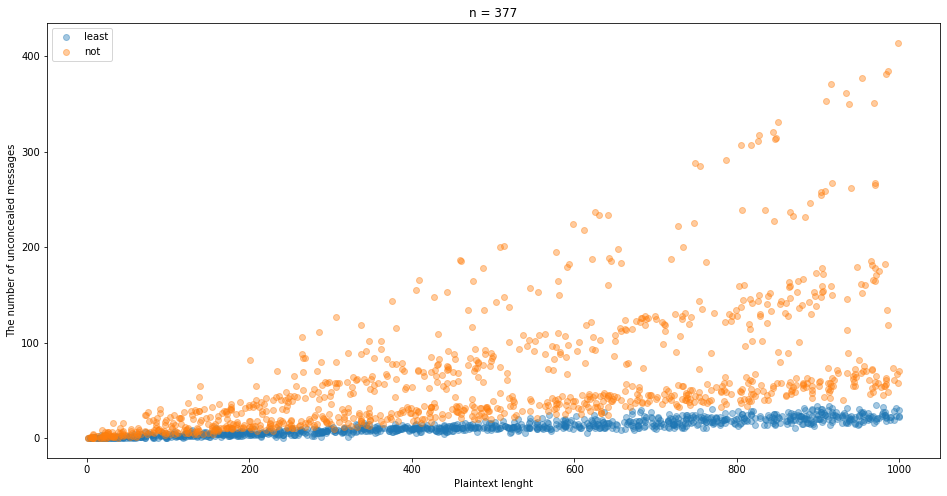

In [12]:
def plotsim2(l, t, figsize=(16,8)):
    plt.figure(figsize=figsize)
    # plt.axhline(y=9, ls='--', color='000000', alpha=0.8)
    # alphas = [1, 0.8, 0.4]
    plt.scatter(x=l['lenght'], y=l['UCC'], alpha=0.4, label='least')
    plt.scatter(x=t['lenght'], y=t['UCC'], alpha=0.4, label="not")

    plt.title(f"n = {n}")
    plt.xlabel('Plaintext lenght')
    plt.ylabel('The number of unconcealed messages')
    plt.legend()
    plt.show()

plotsim2(l, t)

In [15]:
def simulator3(minp, maxp, rep=1, minl=1, maxl=1000):
    lenghts = []
    ucce1 = []
    ucce2 = []
    for r in range(rep):
        n, p, q, phi = randomParams(minp, maxp)
        klst = KeyList(phi)
        UCC = lambda e: UCCnumber(e,p,q)
        leastUCC = min([UCC(e) for e in klst])
        klst_least = []
        dellst = []
        for e in klst:
            if UCC(e) == n: dellst.append(e)
            elif UCC(e) == leastUCC: klst_least.append(e)
        for e in dellst:
            klst.remove(e)
        
        e1 = random.sample(klst, 1)[0]
        e2 = random.sample(klst_least, 1)[0]
        
        lenght = random.randint(minl, maxl)
        texts = generatePlaintext(n, lenght)
        y1 = [encryptRSA(x, n, e1) for x in texts]
        y2 = [encryptRSA(x, n, e2) for x in texts]

        lenghts.append(lenght)
        ucce1.append(countUCC(texts, y1))
        ucce2.append(countUCC(texts, y2))
    
    return lenghts, ucce1, ucce2

ls, ucce1, ucce2 = simulator3(10, 30, rep=1000)

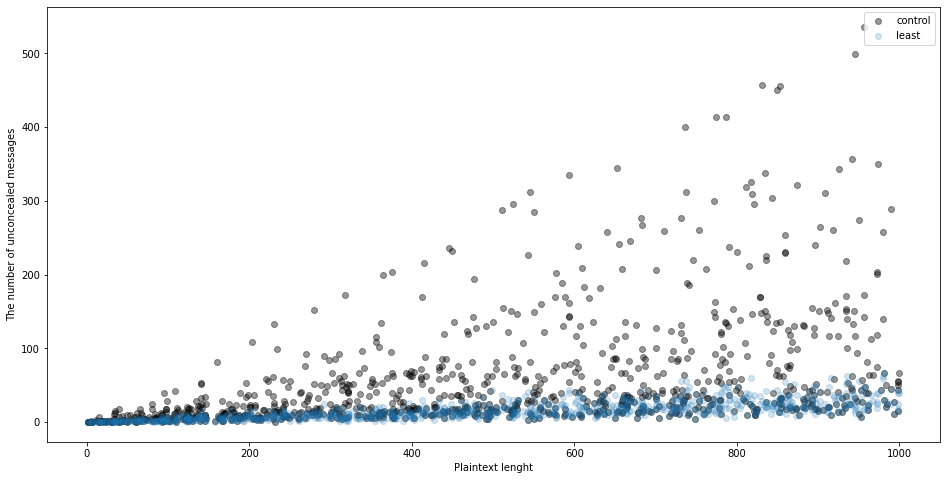

In [21]:
def plotsim3(ls, ucce1, ucce2, figsize=(16,8)):
    plt.figure(figsize=figsize)
    plt.scatter(x=ls, y=ucce1, alpha=0.4, label='control', c='k')
    plt.scatter(x=ls, y=ucce2, alpha=0.2, label="least")

    
    plt.xlabel('Plaintext lenght')
    plt.ylabel('The number of unconcealed messages')
    plt.legend()
    plt.show()

plotsim3(ls, ucce1, ucce2)